# Улучшение процесса нагрева стали

## Постановка задачи

Заказчиком является металургический комбинат, которая специализируется на изготовлении плит из стали.

Требуется подготовить протоип модели машинного обучения, которая должна оптимизировать производственные расходы путем предсказания температуры сплава.

### Описание данных

Данные состоят из следущих файлов:
- **data_arc_new.csv** — данные об электродах;
- **data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);
- **data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);
- **data_gas_new.csv** — данные о продувке сплава газом;
- **data_temp_new.csv** — результаты измерения температуры;
- **data_wire_new.csv** — данные о проволочных материалах (объём);
- **data_wire_time_new.csv** — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах есть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### Целевой признак

**data_temp_new.csv** — результаты измерения температуры

### План работы

**1) Подготовка**
- Приведение названия столбцов к стандартному виду
- Обработка пропусков и дубликатов
- Удаление не нежных признаков или целых файлов
- Удаление выбросов
- Подготовка таблиц для объединения в одну

**2) Обучение модели**
- Выделение целевого признака
- Разделение данных на обучающую и тестовую выборку
- Подбор наилучших параметров методом кросс-валидации
- Отбор наилучшей модели

**3) Тестирование лучшей модели**
- Протестировать модель на тестовой выборке с параметрами, которые были у обучающей модели
- Сравнить метрику обучающей и тестовой модели
- Проверить на сколько лучше или хуже полученная метрика в сравнении с требуемой

## 1 Подготовка

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

In [2]:
data_arc = pd.read_csv(r'C:\Users\Илья\Downloads\Project\data_arc_new.csv', parse_dates=[1, 2]) 
data_bulk = pd.read_csv(r'C:\Users\Илья\Downloads\Project\data_bulk_new.csv') 
data_gas = pd.read_csv(r'C:\Users\Илья\Downloads\Project\data_gas_new.csv') 
data_temp = pd.read_csv(r'C:\Users\Илья\Downloads\Project\data_temp_new.csv', parse_dates=[1]) 
data_wire = pd.read_csv(r'C:\Users\Илья\Downloads\Project\data_wire_new.csv')

data_bulk_time = pd.read_csv(r'C:\Users\Илья\Downloads\Project\data_bulk_time_new.csv',
parse_dates=list(range(1, len(data_bulk.columns)))) 
data_wire_time = pd.read_csv(r'C:\Users\Илья\Downloads\Project\data_wire_time_new.csv',
parse_dates=list(range(1, len(data_wire.columns))))

## Данные об электродах

In [3]:
data_arc.shape

(14876, 5)

In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


**Пропуски**

Пропуски отсутсвуют

In [5]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [6]:
data_arc= data_arc.rename(columns={'Начало нагрева дугой' : 'arc_heating_start', 'Конец нагрева дугой':'arc_heating_finish',\
                         'Активная мощность':'apparent_power', 'Реактивная мощность':'reactive_power'})

In [7]:
data_arc['arc_heating_time'] = (data_arc['arc_heating_finish'] - data_arc['arc_heating_start']).dt.seconds

Зная активную и рективную мощность буду вычислять полную
$$
S = \sqrt{P^{2}+Q^{2}}
$$

In [8]:
data_arc['full_power'] = data_arc.apply(lambda row: math.sqrt(row['apparent_power']**2 + row['reactive_power']**2), axis=1)

In [9]:
data_arc.head()

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,arc_heating_time,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934


In [10]:
heating_rounds = data_arc['key'].value_counts().reset_index(name='heating_rounds').rename(columns={'index': 'key'})

**Аномалии и выбросы**

Построю график ящика с усами для обнаружения аномалий и выбросов

Text(0, 0.5, 'Значение')

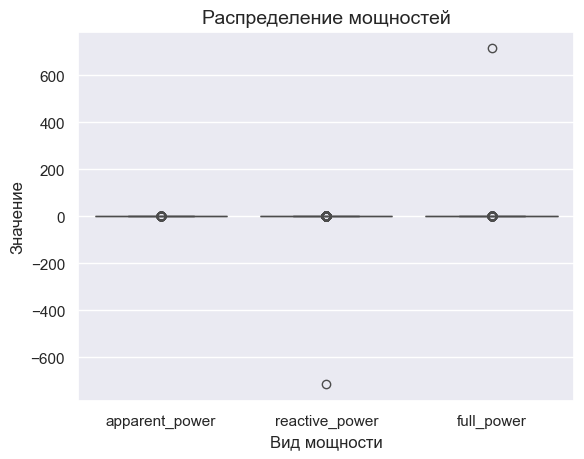

In [11]:
sns.set(style="darkgrid")
sns.boxplot( data_arc[['apparent_power','reactive_power','full_power']])
plt.title('Распределение мощностей', fontsize=14)
plt.xlabel('Вид мощности')
plt.ylabel('Значение')

In [12]:
data_arc.describe()

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,arc_heating_time,full_power
count,14876.000000,14876,14876,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986,171.670946,0.871425
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924,11.000000,0.275718
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175,107.000000,0.578847
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639,147.000000,0.746591
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201,214.000000,1.030427
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,907.000000,715.480272
std,934.571502,NaN,NaN,0.258885,5.873485,98.186803,5.868339


**Удаление выбросов и аномалий**

На основе ящика с усами и описательной стататистики выберу значения для рективной мощности, которые больше -150

In [13]:
data_arc=data_arc.query('reactive_power>0')

Text(0, 0.5, 'Значение')

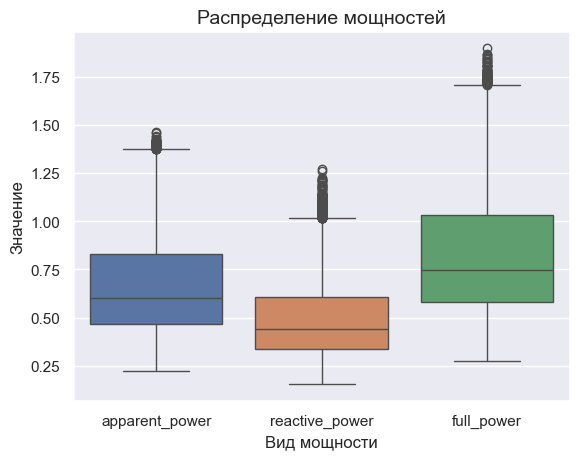

In [14]:
sns.set(style="darkgrid")
sns.boxplot(data_arc[['apparent_power','reactive_power','full_power']])
plt.title('Распределение мощностей', fontsize=14)
plt.xlabel('Вид мощности')
plt.ylabel('Значение')

Text(0, 0.5, 'Секунды')

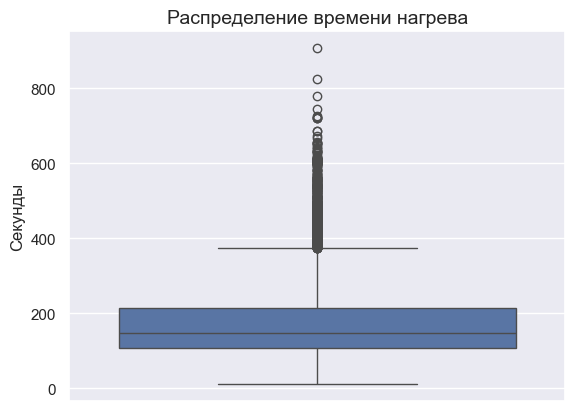

In [15]:
sns.set(style="darkgrid")
sns.boxplot( data = data_arc['arc_heating_time'])
plt.title('Распределение времени нагрева', fontsize=14)
plt.ylabel('Секунды')

Так же удалю выбросы по времени, которые больше 390 сек

In [16]:
data_arc=data_arc.query('arc_heating_time<390')

In [17]:
data_arc.describe()

,key,arc_heating_start,arc_heating_finish,apparent_power,reactive_power,arc_heating_time,full_power
count,14335.000000,14335,14335,14335.000000,14335.000000,14335.000000,14335.000000
mean,1614.503802,2019-07-05 11:41:52.353609984,2019-07-05 11:44:32.433903104,0.662474,0.487008,160.080293,0.823100
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777,11.000000,0.275718
25%,807.000000,2019-06-04 00:06:21.500000,2019-06-04 00:11:05.500000,0.466690,0.336886,104.000000,0.578159
50%,1613.000000,2019-07-02 22:01:08,2019-07-02 22:06:49,0.599495,0.441371,143.000000,0.745467
75%,2430.000000,2019-08-07 23:28:21.500000,2019-08-07 23:30:41.500000,0.830497,0.608806,203.000000,1.030845
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,389.000000,1.898158
std,934.221739,NaN,NaN,0.259059,0.197700,77.862624,0.323652


In [18]:
data_arc = data_arc.drop(columns=['arc_heating_start','arc_heating_finish'],axis=1)

In [19]:
global_data_arc = data_arc.groupby(by = 'key').sum()
global_data_arc = global_data_arc.merge(heating_rounds, on='key')
global_data_arc.head()

,key,apparent_power,reactive_power,arc_heating_time,full_power,heating_rounds
0,1,3.036730,2.142821,1098,3.718736,5
1,2,2.139408,1.453357,811,2.588349,4
2,3,4.063641,2.937457,655,5.019223,5
3,4,2.706489,2.056992,741,3.400038,4
4,5,1.791330,1.379326,454,2.261672,4


## Данные о подаче сыпучих материалов (объём)

In [20]:
data_bulk.shape

(3129, 16)

In [21]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


In [22]:
data_bulk.value_counts()

Series([], Name: count, dtype: int64)

In [23]:
data_bulk.isnull().sum() * 100 / len(data_bulk)

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

**Пропуски**

Заметно, что в Bulk 12,14,15 меньше всего пропусков. Так как востановить такое большое колл-во пропусков в других колонках нереально. Заменю пропуски 0 все так же из-за невозможности востановить значения

In [24]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [25]:
data_bulk = data_bulk.rename(columns={'Bulk 1': 'bulk_1',
    'Bulk 2': 'bulk_2',
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 5': 'bulk_5',
    'Bulk 6': 'bulk_6',
    'Bulk 7': 'bulk_7',
    'Bulk 8': 'bulk_8',
    'Bulk 9': 'bulk_9',
    'Bulk 10': 'bulk_10',
    'Bulk 11': 'bulk_11',
    'Bulk 12': 'bulk_12',
    'Bulk 13': 'bulk_13',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15'})

In [26]:
data_bulk = data_bulk.fillna(0)

In [27]:
data_bulk = data_bulk.astype('int')

In [28]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Text(0, 0.5, 'Значение')

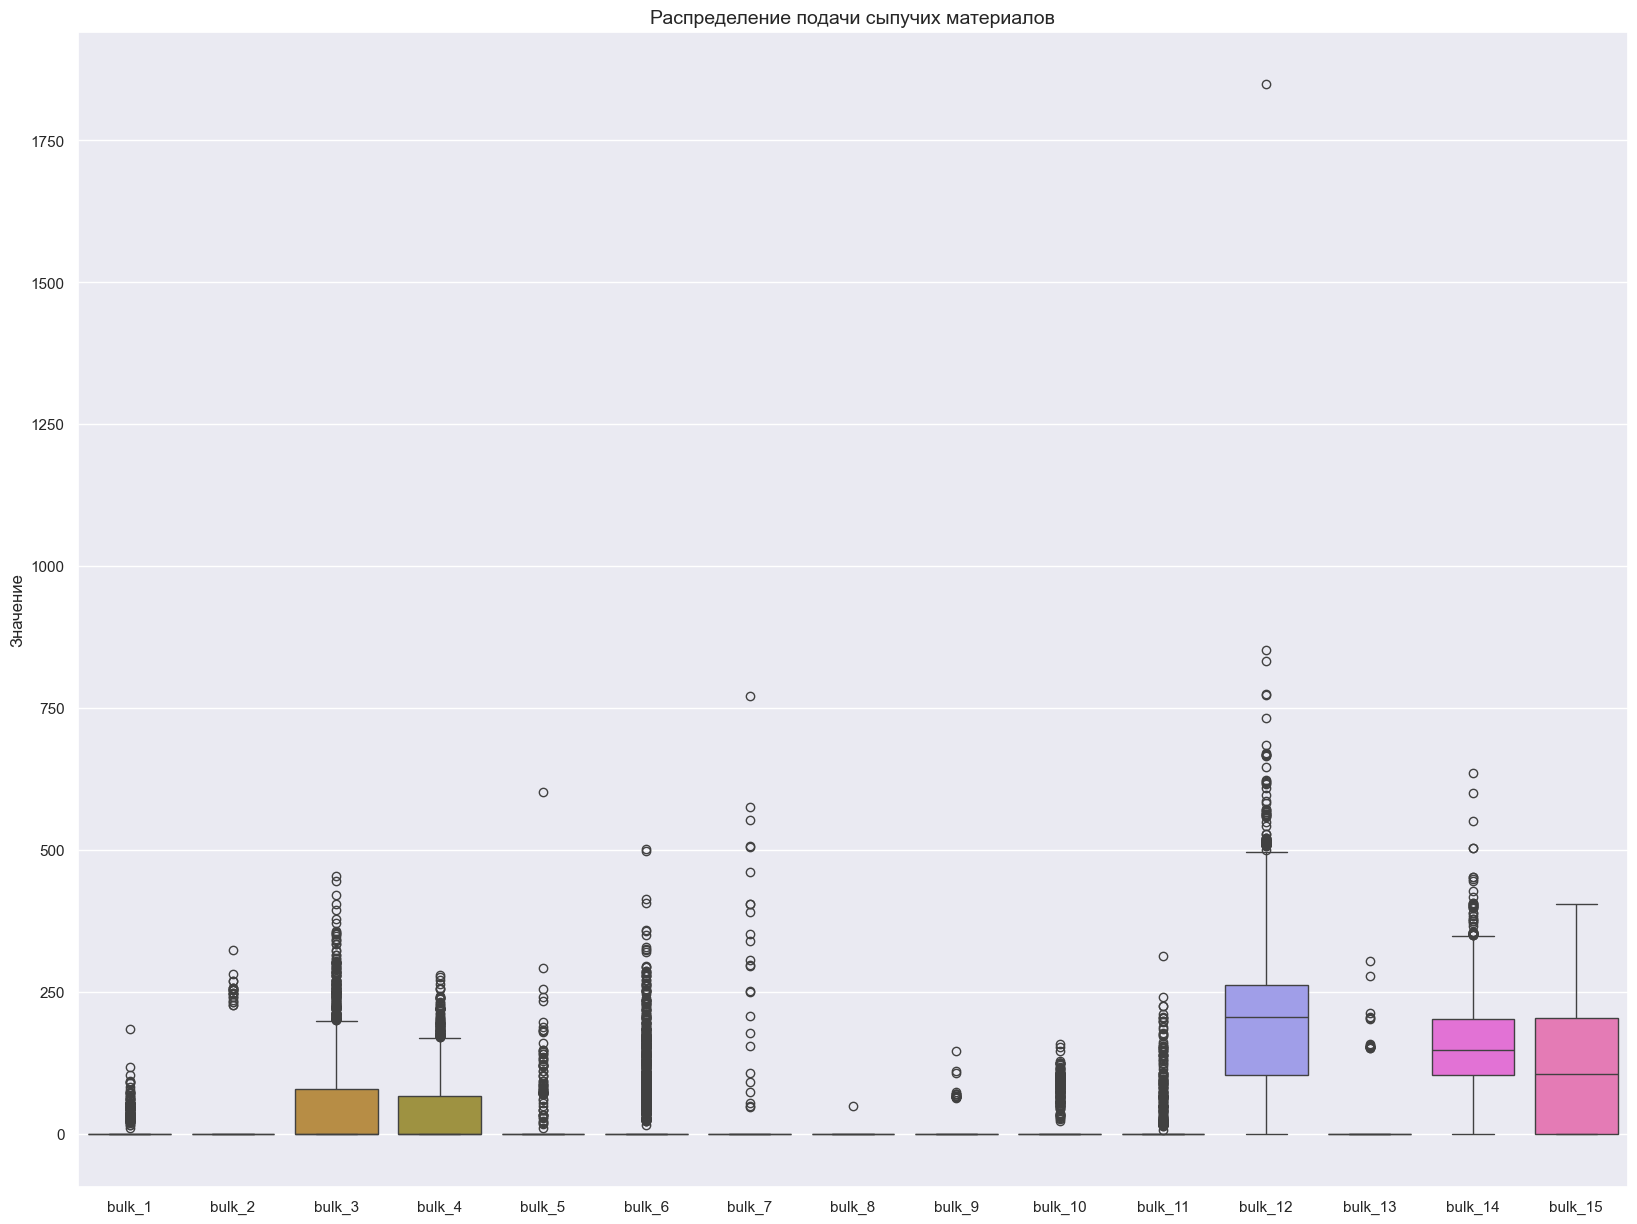

In [29]:
plt.figure(figsize=(20, 15))
sns.set(style="darkgrid")
sns.boxplot(data_bulk.iloc[:, 1:])
plt.title('Распределение подачи сыпучих материалов', fontsize=14)
plt.ylabel('Значение')

In [30]:
data_bulk = data_bulk.query('bulk_12 < 600')

In [31]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000
mean,1626.624638,2.895465,1.790608,47.363461,33.723705,2.650692,21.918623,2.326793,0.015761,0.466388,4.687359,4.357028,200.478289,0.950466,151.785462,115.113220
std,934.004783,10.971840,21.285555,74.367568,55.967953,20.984264,55.477210,31.217621,0.878791,6.174056,20.167367,22.763597,144.032542,13.067225,80.040598,84.429218
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1626.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2436.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,261.000000,0.000000,202.000000,204.000000
max,3241.000000,118.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,597.000000,278.000000,601.000000,405.000000


In [32]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152


## Данные о продувке сплава газом

In [33]:
data_gas.shape

(3239, 2)

In [34]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [35]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas_1'})

In [36]:
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Text(0, 0.5, 'Значение')

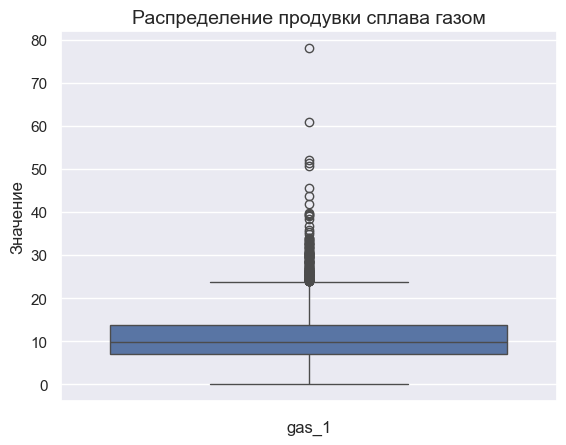

In [37]:
sns.set(style="darkgrid")
sns.boxplot(data_gas['gas_1'])
plt.title('Распределение продувки сплава газом', fontsize=14)
plt.xlabel('gas_1')
plt.ylabel('Значение')

In [38]:
data_gas = data_gas.query('gas_1<40')

In [39]:
data_gas.describe()

,key,gas_1
count,3231.000000,3231.000000
mean,1622.895388,10.898018
std,935.208144,5.840039
min,1.000000,0.008399
25%,814.500000,7.036017
50%,1623.000000,9.824798
75%,2432.500000,13.727817
max,3241.000000,39.728826


In [40]:
data_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


## Результаты измерения температуры

In [41]:
data_temp.shape

(18092, 3)

In [42]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [43]:
data_temp.isnull().sum() * 100 / len(data_temp)

key              0.000000
Время замера     0.000000
Температура     18.942074
dtype: float64

**Пропуски**

В колонке температура 19% пропусков, что доостаточно много, но все же не критично. Данные пропуски вместо замены на нули  удалю.

In [44]:
data_temp = data_temp.rename(columns={'Время замера': 'measurement_time', 'Температура':'temperature'})

In [45]:
data_temp = data_temp.dropna().reset_index(drop=True)

In [46]:
data_temp.isnull().sum() * 100 / len(data_temp)

key                 0.0
measurement_time    0.0
temperature         0.0
dtype: float64

In [47]:
data_temp.head()

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [48]:
data_temp['temperature'] = data_temp['temperature'].astype('int')

**Аномалии и выбросы**

При помощи ящика с усами и описательной статистики устраню аномалии и выбросы

Text(0, 0.5, 'Температура')

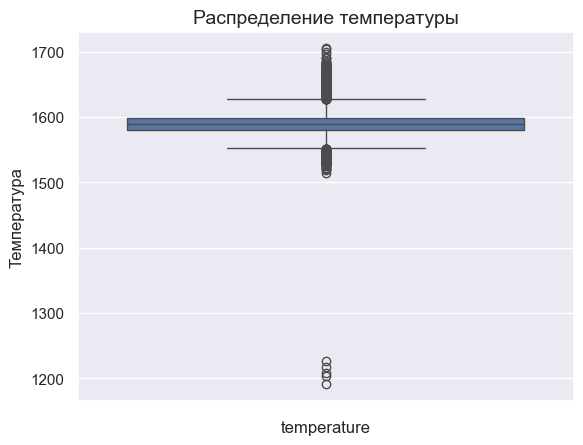

In [49]:
sns.set(style="darkgrid")
sns.boxplot(data_temp['temperature'])
plt.title('Распределение температуры', fontsize=14)
plt.xlabel('temperature')
plt.ylabel('Температура')

In [50]:
data_temp['temperature'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temperature, dtype: float64

In [51]:
data_temp = data_temp.query('temperature>1500')

In [52]:
heating_rounds_2 = data_temp['key'].value_counts().reset_index(name='heating_rounds_2').rename(columns={'index': 'key'}).sort_values(by='key', ascending=False)


In [53]:
heating_rounds_2.query('heating_rounds_2 ==1').tail(20)

,key,heating_rounds_2
2963,2517,1
2982,2516,1
2981,2515,1
2980,2514,1
2979,2513,1
2978,2512,1
2977,2511,1
2976,2510,1
2975,2509,1
2974,2508,1


Видно, что начиная с 2500 ключа колл-во иттераций равно 1, а это значит, что данные с этого ключа можно удалить так как они не будут нести для меня смысловой нагрузки так как у них нету ни начала ни конца

Для дальнейшего лучшего обучени модели найду первое и последнеее время замера, а так же темперетуру на этих участках. Так же найду время самого замера

In [54]:
general_data_temp = data_temp.query('key < 2500 and key!=195 and key!=279' )
general_data_temp = general_data_temp.groupby(by='key').agg(['first', 'last']).reset_index()
general_data_temp.columns = ['key', 'first_temp_ts', 'finish_temp_ts', 'first_temp', 'finish_temp']
general_data_temp['time_diff'] = general_data_temp['finish_temp_ts'] - general_data_temp['first_temp_ts']
general_data_temp['time_diff'] = general_data_temp['time_diff'].dt.seconds

In [55]:
general_data_temp

,key,first_temp_ts,finish_temp_ts,first_temp,finish_temp,time_diff
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571,1613,1714
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581,1602,1265
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596,1599,1753
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601,1625,1220
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576,1602,1536
...,...,...,...,...,...,...
2470,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570,1591,1380
2471,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554,1591,1705
2472,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571,1589,962
2473,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,1591,1594,1520


## Данные о проволочных материалах (объём)

In [56]:
data_wire.shape

(3081, 10)

In [57]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [58]:
data_wire.isnull().sum() * 100 / len(data_wire)

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

**Пропуски**

Аналогично даным о сыпучих материалах заменим пропуски на нули.

In [59]:
data_wire = data_wire.fillna(0)

In [60]:
data_wire = data_wire.rename(columns={'Wire 1': 'wire_1',
    'Wire 2': 'wire_2',
    'Wire 3': 'wire_3',
    'Wire 4': 'wire_4',
    'Wire 5': 'wire_5',
    'Wire 6': 'wire_6',
    'Wire 7': 'wire_7',
    'Wire 8': 'wire_8',
    'Wire 9': 'wire_9'})

In [61]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Text(0, 0.5, 'Значение')

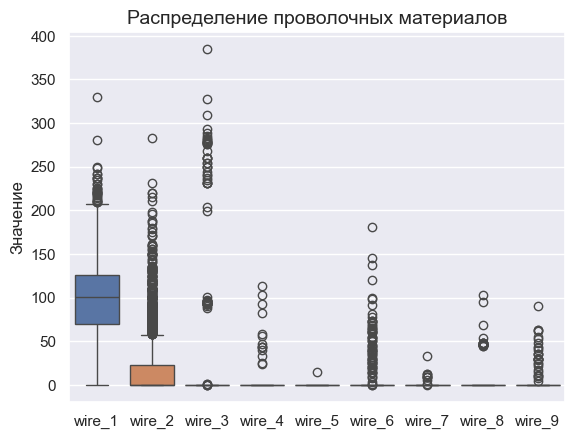

In [62]:
sns.set(style="darkgrid")
sns.boxplot(data_wire.iloc[:, 1:])
plt.title('Распределение проволочных материалов', fontsize=14)
plt.ylabel('Значение')

Так как в wire_1 пропксков меньше всего, то аномалии и выбросы будем удалять по этому столбцу

In [63]:
data_wire = data_wire.query('wire_1<300')

In [64]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000
mean,1623.362338,99.969648,17.695972,3.875782,0.261104,0.004913,1.138065,0.035854,0.330805,0.321596
std,933.141428,42.646580,33.510260,30.315258,4.294559,0.272660,8.959543,0.774316,4.393387,3.807517
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,822.750000,70.260839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1618.500000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.250000,125.798398,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,280.987214,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


In [65]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Данные о подаче сыпучих материалов (время)

In [66]:
data_bulk_time.shape

(3129, 16)

In [67]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB


In [68]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Так как в данном ДФ данные связаны с временем, но временем которое не показывает какой либо нагрев, то от данного ДФ откажусь

## Данные о проволочных материалах (время)

In [69]:
data_wire_time.shape

(3081, 10)

In [70]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [71]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Так как в данном ДФ данные связаны с временем, но временем которое не показывает какой либо нагрев, то от данного ДФ откажусь 

### Вывод

- Названия столбцов были приведены к стандартному типу
- Былу удалены или обработаны пропуски
- Убрали признаки, которые не несли смысловой нагрузки
- Были удалены аномалии и выбросы
- В таблице с целевым признаком удалили признаки начиная с ключа 2500
- Отказались от ДФ, которые не несли в себе полезной информации
- Таблицы были подготовлены для итогового объединения

## 2 Объединение в общий ДФ

In [72]:
df = global_data_arc.merge(data_bulk, on='key', how='inner')
df = df.merge(data_gas, on='key', how='inner')
df = df.merge(general_data_temp, on='key', how='inner')
df = df.merge(data_wire, on='key', how='inner')

In [73]:
df.shape

(2304, 36)

In [74]:
df.tail()

,key,apparent_power,reactive_power,arc_heating_time,full_power,heating_rounds,bulk_1,bulk_2,bulk_3,bulk_4,...,time_diff,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2299,2495,3.168133,2.210936,723,3.868721,4,0,0,21,0,...,1380,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2300,2496,4.174918,2.872031,940,5.070316,6,0,0,0,63,...,1705,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2301,2497,3.605239,2.452092,569,4.360918,3,0,0,0,85,...,962,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2302,2498,3.202310,2.239820,750,3.909917,5,0,0,90,0,...,1520,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2303,2499,1.737084,1.296836,883,2.169252,4,0,0,47,0,...,1537,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
df = df.drop('key', axis=1)

In [76]:
df = df.drop(columns=['first_temp_ts','finish_temp_ts'])

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   apparent_power    2304 non-null   float64
 1   reactive_power    2304 non-null   float64
 2   arc_heating_time  2304 non-null   int32  
 3   full_power        2304 non-null   float64
 4   heating_rounds    2304 non-null   int64  
 5   bulk_1            2304 non-null   int32  
 6   bulk_2            2304 non-null   int32  
 7   bulk_3            2304 non-null   int32  
 8   bulk_4            2304 non-null   int32  
 9   bulk_5            2304 non-null   int32  
 10  bulk_6            2304 non-null   int32  
 11  bulk_7            2304 non-null   int32  
 12  bulk_8            2304 non-null   int32  
 13  bulk_9            2304 non-null   int32  
 14  bulk_10           2304 non-null   int32  
 15  bulk_11           2304 non-null   int32  
 16  bulk_12           2304 non-null   int32  


Согласно требованию заказчика в итоговом ДФ должно остаться не более 2332 ключей. По итогу вышло 2304

Помимом колонки **key** удалю колонки с типом datetime64[ns] так, как они не будут нести в себе много информации для обучения модели. Так как уже есть колонка с временем нагрева в секундах

In [78]:
df.head()

,apparent_power,reactive_power,arc_heating_time,full_power,heating_rounds,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,time_diff,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,3.036730,2.142821,1098,3.718736,5,0,0,0,43,0,...,1714,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.139408,1.453357,811,2.588349,4,0,0,0,73,0,...,1265,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.063641,2.937457,655,5.019223,5,0,0,0,34,0,...,1753,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.706489,2.056992,741,3.400038,4,0,0,0,81,0,...,1220,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.791330,1.379326,454,2.261672,4,0,0,0,78,0,...,1536,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


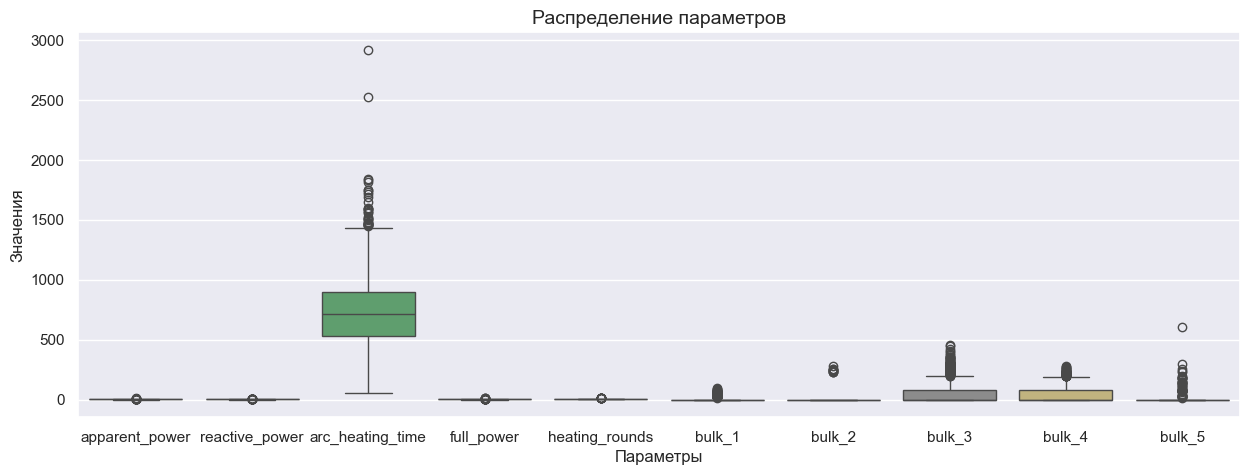

In [79]:
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.boxplot(df.iloc[:, 0:10])
plt.title('Распределение параметров', fontsize=14)
plt.xlabel('Параметры')
plt.ylabel('Значения')
plt.show()

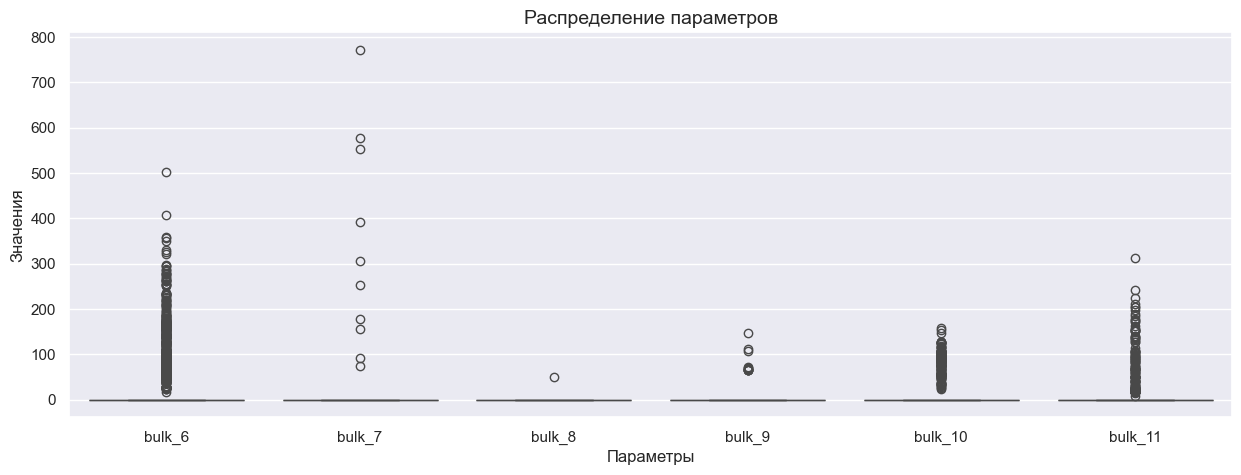

In [80]:
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.boxplot(df.iloc[:, 10:16])
plt.title('Распределение параметров', fontsize=14)
plt.xlabel('Параметры')
plt.ylabel('Значения')
plt.show()

In [81]:
df.iloc[:, 0:16].describe()

,apparent_power,reactive_power,arc_heating_time,full_power,heating_rounds,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,3.003424,2.211868,726.603733,3.734015,4.670139,3.010851,1.074653,47.371094,37.131076,2.512153,22.519097,1.454427,0.021267,0.422309,5.070747,4.269097
std,1.165467,0.864961,284.828849,1.450215,1.560379,11.124073,16.310214,75.280479,58.584714,22.177174,55.823162,26.434504,1.020833,6.116757,20.958589,22.624473
min,0.267676,0.193856,57.000000,0.331897,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.179221,1.603352,528.750000,2.708549,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.921990,2.145101,712.000000,3.625521,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.698501,2.733942,897.000000,4.616773,6.000000,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.632350,8.572990,2919.000000,14.466533,15.000000,94.000000,282.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000


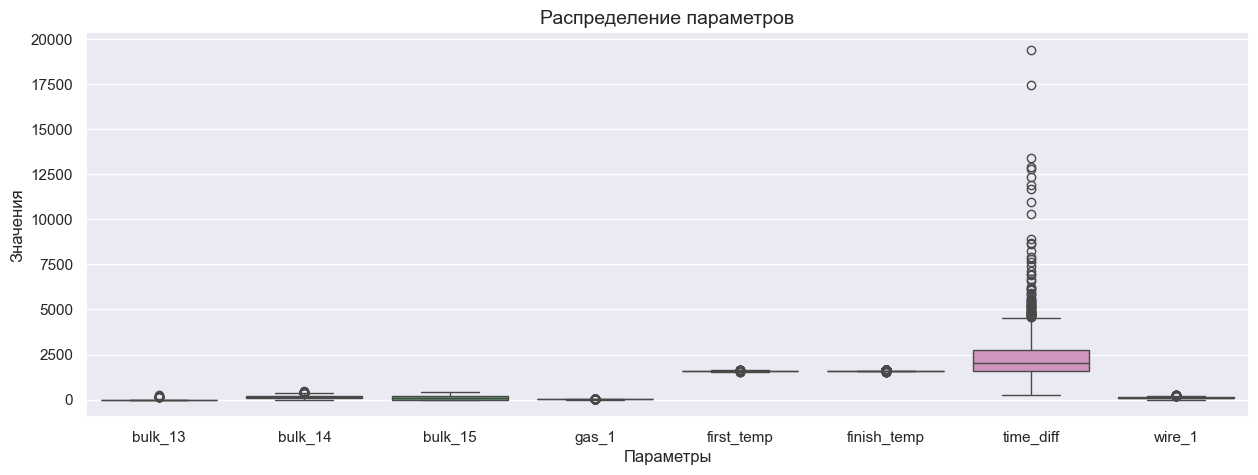

In [82]:
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.boxplot(df.iloc[:, 17:25])
plt.title('Распределение параметров', fontsize=14)
plt.xlabel('Параметры')
plt.ylabel('Значения')
plt.show()

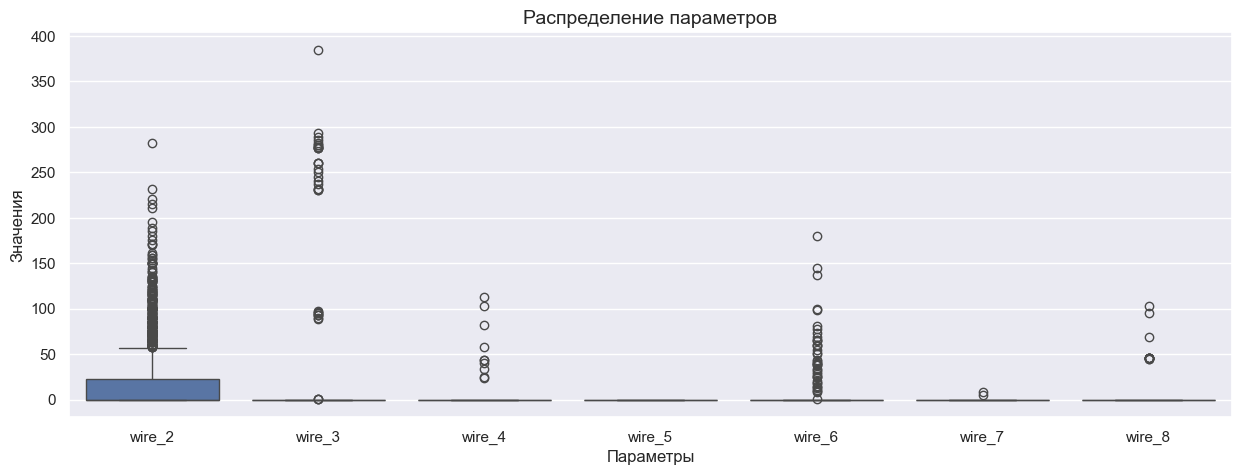

In [83]:
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.boxplot(df.iloc[:, 25:32])
plt.title('Распределение параметров', fontsize=14)
plt.xlabel('Параметры')
plt.ylabel('Значения')
plt.show()

In [84]:
df.iloc[:, 17:32].describe()

,bulk_13,bulk_14,bulk_15,gas_1,first_temp,finish_temp,time_diff,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.0,2304.000000,2304.000000,2304.000000
mean,0.946615,152.755208,119.889323,11.212690,1587.303385,1593.342448,2290.704427,102.217118,17.631211,3.148729,0.245358,0.0,0.910687,0.005870,0.294723
std,12.833522,79.814254,84.504802,5.893244,23.510504,11.082308,1243.986014,42.874189,33.527504,27.904143,4.222584,0.0,8.417925,0.205607,4.322784
min,0.000000,0.000000,0.000000,0.008399,1519.000000,1543.000000,270.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,105.000000,0.000000,7.265603,1571.000000,1587.000000,1575.000000,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.000000,149.000000,107.000000,10.061914,1587.000000,1593.000000,2034.000000,101.081759,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.000000,204.000000,204.000000,14.119233,1603.000000,1598.000000,2771.000000,127.342801,23.153520,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,278.000000,450.000000,405.000000,39.728826,1660.000000,1653.000000,19409.000000,249.958786,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401


In [85]:
df.isnull().sum() * 100 / len(df)

apparent_power      0.0
reactive_power      0.0
arc_heating_time    0.0
full_power          0.0
heating_rounds      0.0
bulk_1              0.0
bulk_2              0.0
bulk_3              0.0
bulk_4              0.0
bulk_5              0.0
bulk_6              0.0
bulk_7              0.0
bulk_8              0.0
bulk_9              0.0
bulk_10             0.0
bulk_11             0.0
bulk_12             0.0
bulk_13             0.0
bulk_14             0.0
bulk_15             0.0
gas_1               0.0
first_temp          0.0
finish_temp         0.0
time_diff           0.0
wire_1              0.0
wire_2              0.0
wire_3              0.0
wire_4              0.0
wire_5              0.0
wire_6              0.0
wire_7              0.0
wire_8              0.0
wire_9              0.0
dtype: float64

Так как все значения востановить невозможно, а в некоторых колонках заменять пропуски на 0 не очень хорошая идея, так как может сильно просесть качество модели, то удалю их

Text(0.5, 1.0, 'Корреляция признаков')

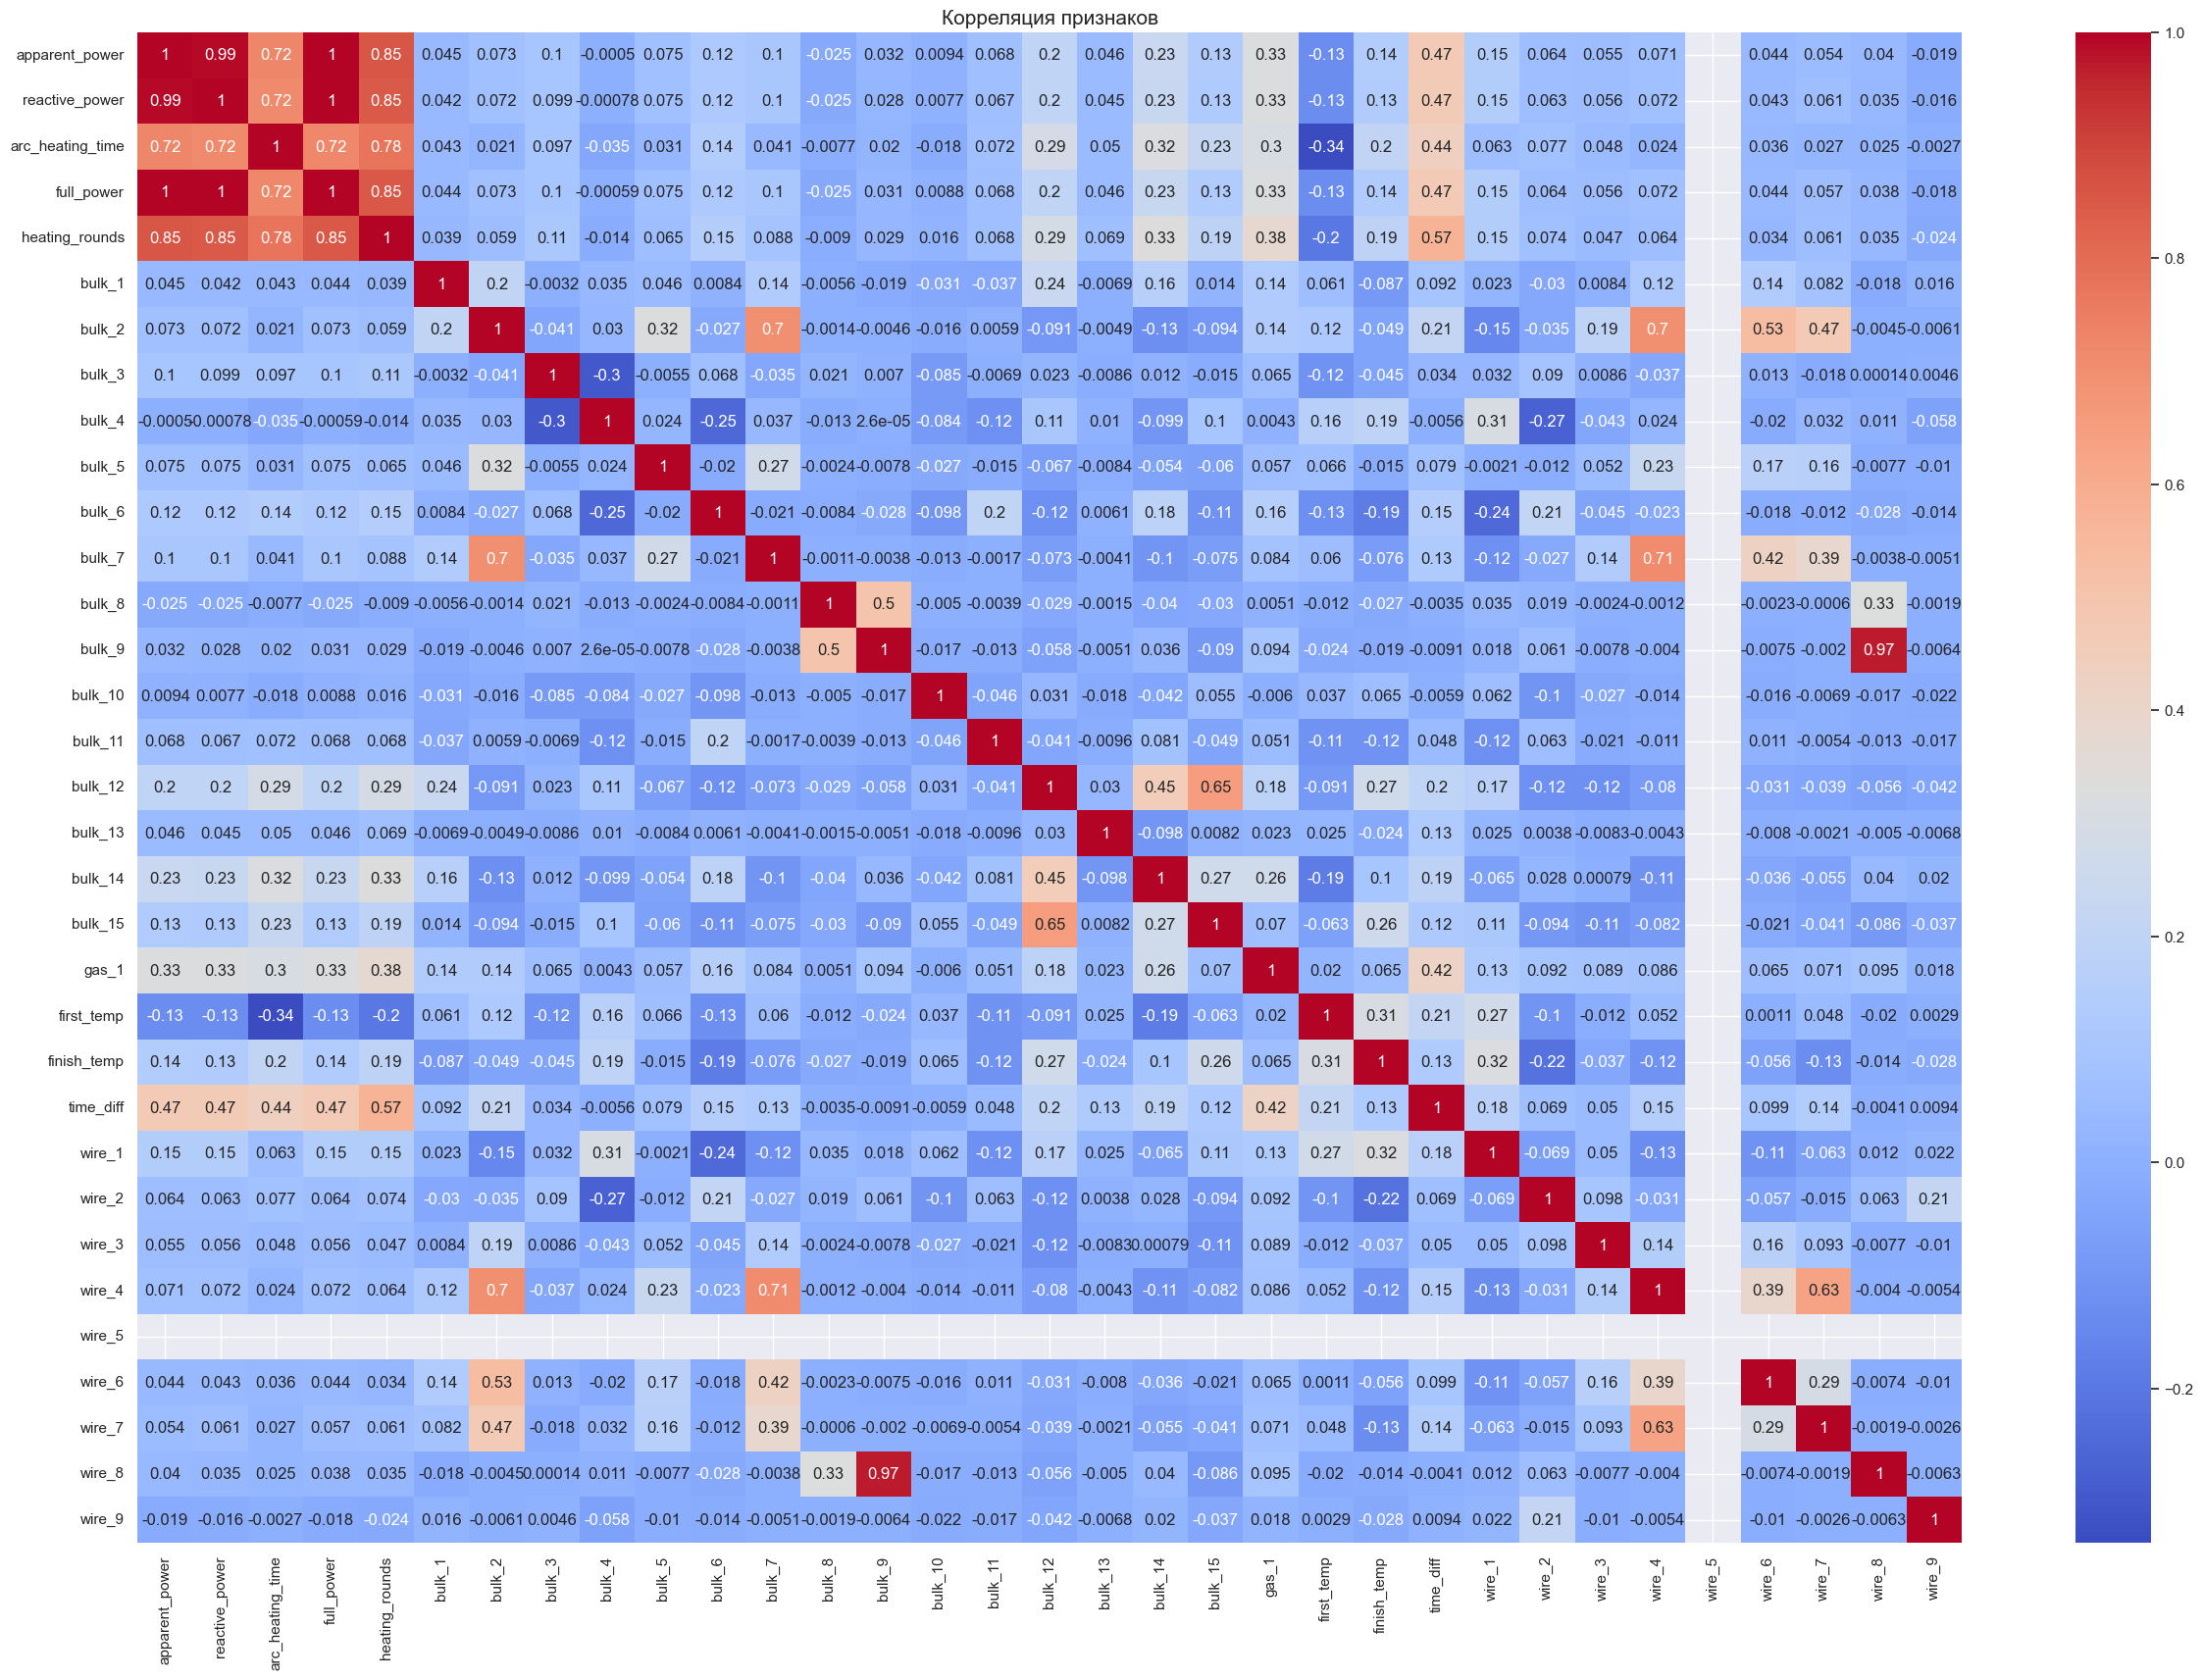

In [86]:
plt.figure(figsize=(30, 20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm');
plt.title('Корреляция признаков', fontsize=15)

Высокая корреляция между признаками

apparent_power, reactive_power, arc_heating_time, full_power, heating_rounds, bulk_9, wire_8

### Вывод

- Объединил данные в один общий ДФ
- Удалили пропуски
- Убрал не нужные столбцы
- Выявил высокую корреляцию между признаками apparent_power, reactive_power, arc_heating_time, full_power, heating_rounds

## 3 Обучение модели

In [87]:
features = df.drop('finish_temp', axis=1)
target = df['finish_temp']
RND = 170723

In [88]:
f_train, f_test, t_train, t_test = train_test_split(features, target,\
                                                    test_size=0.25, random_state=RND, shuffle=True)

In [89]:
f_train.shape, f_test.shape, t_train.shape, t_test.shape

((1728, 32), (576, 32), (1728,), (576,))

## CatBoostRegressor

In [90]:
%%time
model = CatBoostRegressor()
params = {
    'n_estimators': [4000], # првоерял так же значения от 500 до 3500 с шагом в 500
    'max_depth': [3], # првоерял так же значения от 2 до 5
    'loss_function' : ['MAE'],
    'random_state': [RND]
}
grid_search = GridSearchCV(model, params, cv=10, scoring='neg_mean_absolute_error')
grid_search.fit(f_train, t_train, verbose=200)


print(grid_search.best_params_)
print(abs(grid_search.best_score_))



0:	learn: 7.9979219	total: 136ms	remaining: 9m 2s
200:	learn: 6.3276097	total: 218ms	remaining: 4.12s
400:	learn: 5.8464530	total: 289ms	remaining: 2.6s
600:	learn: 5.5134605	total: 363ms	remaining: 2.06s
800:	learn: 5.2978494	total: 442ms	remaining: 1.77s
1000:	learn: 5.1373095	total: 521ms	remaining: 1.56s
1200:	learn: 5.0039665	total: 599ms	remaining: 1.4s
1400:	learn: 4.8947778	total: 675ms	remaining: 1.25s
1600:	learn: 4.7977002	total: 747ms	remaining: 1.12s
1800:	learn: 4.7113533	total: 823ms	remaining: 1s
2000:	learn: 4.6395244	total: 902ms	remaining: 901ms
2200:	learn: 4.5655313	total: 981ms	remaining: 802ms
2400:	learn: 4.5100614	total: 1.06s	remaining: 705ms
2600:	learn: 4.4658833	total: 1.13s	remaining: 609ms
2800:	learn: 4.4177276	total: 1.21s	remaining: 517ms
3000:	learn: 4.3859188	total: 1.28s	remaining: 427ms
3200:	learn: 4.3392443	total: 1.36s	remaining: 339ms
3400:	learn: 4.2992573	total: 1.44s	remaining: 253ms
3600:	learn: 4.2681353	total: 1.51s	remaining: 168ms
3800:

In [91]:
best_cat = grid_search.best_params_

## LGBMRegressor

In [92]:
%%time
model = LGBMRegressor()

param = {
    'n_estimators' : [1, 2, 5, 10],
    'objective' : ['MAE'],
    'random_state' : [RND]
    
}

grid_lgb = GridSearchCV(model, param, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_lgb.fit(f_train, t_train)

print(grid_lgb.best_params_)
print(abs(grid_lgb.best_score_))

{'n_estimators': 10, 'objective': 'MAE', 'random_state': 170723}
7.144692150243691
CPU times: total: 266 ms
Wall time: 1.26 s


In [93]:
best_lgb = grid_lgb.best_params_

## LinearRegression

Удалим по одному признаку из пары корреляций выше 0.9

In [94]:
f_train_lin = f_train.drop(columns=['reactive_power', 'full_power', 'bulk_9'])
f_test_lin = f_test.drop(columns=['reactive_power', 'full_power', 'bulk_9'])

scaler = StandardScaler()
scaler.fit(f_train_lin)

f_train_lin_scaler = scaler.transform(f_train_lin)
f_test_lin_scaler = scaler.transform(f_test_lin)

In [95]:
%%time
model = LinearRegression()

param = {
    'fit_intercept': [True, False],    
    'copy_X': [True, False]
}

grid_lin = GridSearchCV(model, param, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_lin.fit(f_train_lin_scaler, t_train)

print(grid_lin.best_params_)
print(abs(grid_lin.best_score_))

{'copy_X': True, 'fit_intercept': False}
2675.628594778472
CPU times: total: 641 ms
Wall time: 419 ms


In [96]:
best_lin = grid_lin.best_params_

## 4 Тестирование лучшей модели

In [97]:
%%time
model = CatBoostRegressor(**best_cat).fit(f_train, t_train, verbose=1000)
predict = model.predict(f_test)
result_mae =  mean_absolute_error(t_test, predict)
r2 = r2_score(t_test, predict)
print('MAE:', result_mae)
print(r2)


0:	learn: 8.0521923	total: 1.03ms	remaining: 4.1s
1000:	learn: 5.2234414	total: 1.13s	remaining: 3.4s
2000:	learn: 4.7063658	total: 2.24s	remaining: 2.24s
3000:	learn: 4.4129790	total: 3.32s	remaining: 1.1s
3999:	learn: 4.2384215	total: 4.41s	remaining: 0us
MAE: 6.072419361292871
0.3947663945033377
CPU times: total: 31.4 s
Wall time: 4.61 s


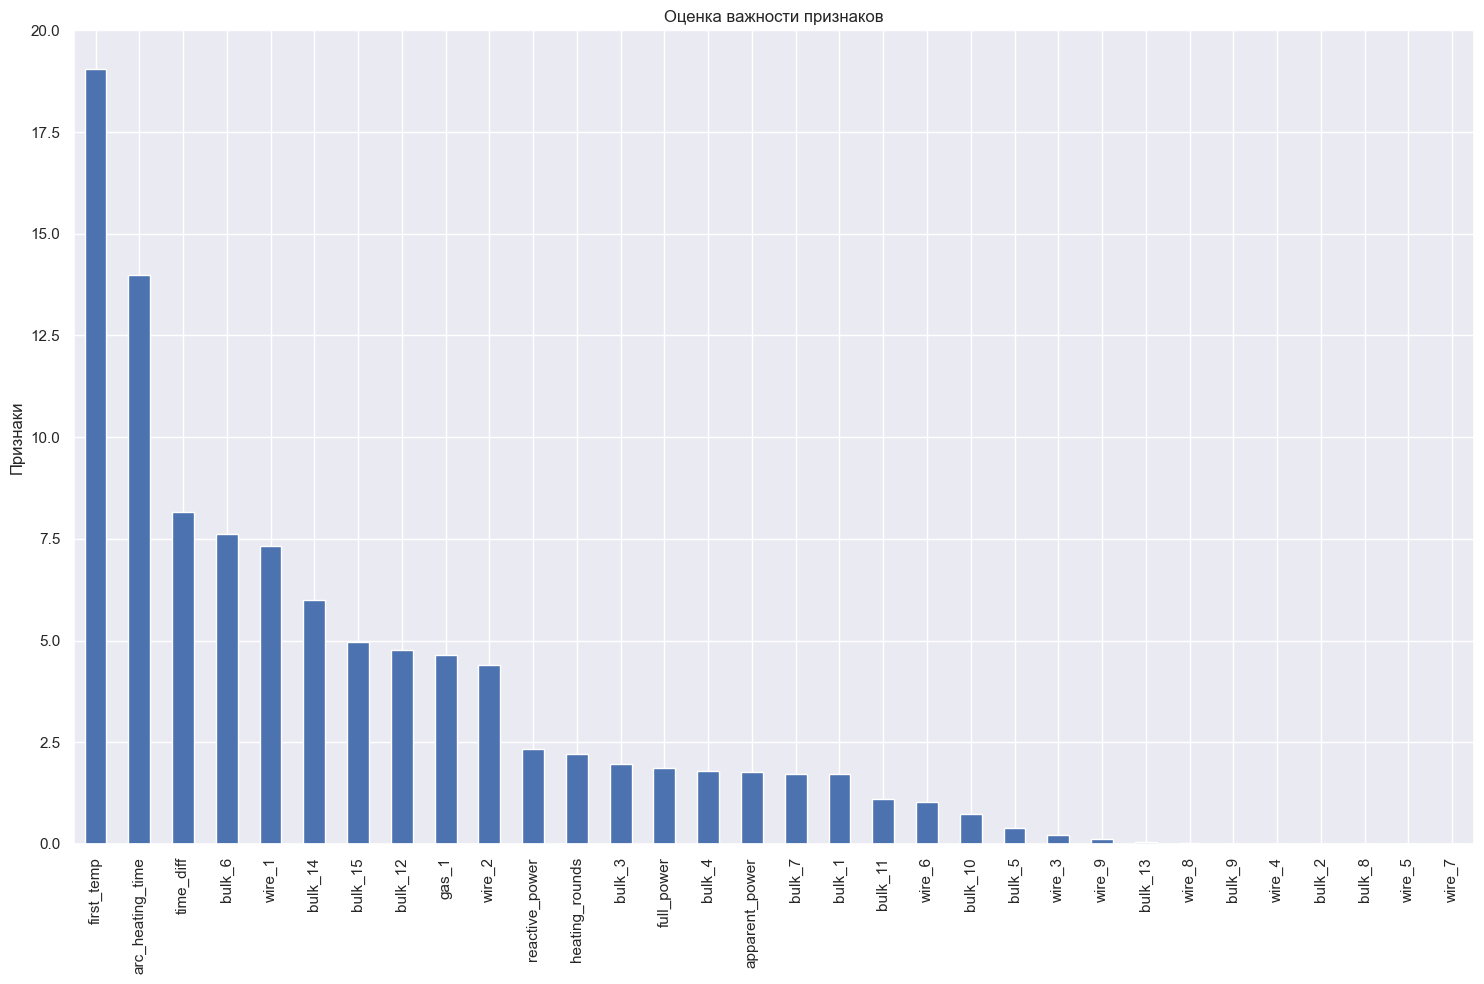

In [98]:
feature_imp = pd.Series(model.feature_importances_, index=f_test.columns).sort_values(ascending=False)
      
fig, ax = plt.subplots(figsize=(15,10))
feature_imp.plot.bar(ax=ax)
_ = ax.set_title('Оценка важности признаков')
_ = ax.set_ylabel('Признаки')
fig.tight_layout()

По графику важности признаков можно заметить, что наиболее важными для обучения модели являются признаки **first_temp и arc-heating_time** для возможного улучшения метрики их никак нельзя удалять. Так же есть признки которые не играют роли при обучении **wire_7, wire_5, wire_4, bulk_8, wire_8, bulk_9,  wire_9, bulk_2, wire_3** их можно удалить и проверить повысится ли качество метрики                                   

In [99]:
filt_features_train = f_train.copy()
filt_features_test = f_test.copy()
filt_features_train = filt_features_train.drop(columns=['wire_7', 'wire_5', 'wire_4', 'bulk_8', 'wire_8', 'bulk_9',\
                                                       'wire_9','bulk_2','wire_3'])
filt_features_test = filt_features_test.drop(columns=['wire_7', 'wire_5', 'wire_4', 'bulk_8', 'wire_8', 'bulk_9',\
                                                     'wire_9','bulk_2', 'wire_3'])

In [100]:
%%time
model = CatBoostRegressor(**best_cat).fit(filt_features_train, t_train, verbose=1000)
predict = model.predict(filt_features_test)
result_mae =  mean_absolute_error(t_test, predict)
r2 = r2_score(t_test, predict)
print('MAE:', result_mae)
print('R2:', r2)

0:	learn: 8.0549353	total: 1.09ms	remaining: 4.38s
1000:	learn: 5.1765175	total: 1.08s	remaining: 3.23s
2000:	learn: 4.6808469	total: 2.12s	remaining: 2.12s
3000:	learn: 4.4105453	total: 3.21s	remaining: 1.07s
3999:	learn: 4.2224361	total: 4.24s	remaining: 0us
MAE: 6.003284443907166
R2: 0.39598338511377595
CPU times: total: 29.7 s
Wall time: 4.45 s


Как можно видеть качество метрики возросло с 6.1 до 6

In [101]:
model = DummyRegressor(strategy="mean").fit(f_train, t_train)
pred = model.predict(f_test)
result_mae =  mean_absolute_error(t_test, pred)
r2 = r2_score(t_test, pred)
print('MAE:', result_mae)
print('R2:', r2)

MAE: 7.668866946373457
R2: -0.00014858461515987464


# Отчет

Описание этапов и полученные результаты

**1) Подготовка**
- Названия столбцов были приведены к стандартному типу
- Былу удалены или обработаны пропуски
- Убрали признаки, которые не несли смысловой нагрузки
- Были удалены аномалии и выбросы
- В таблице с целевым признаком удалили признаки начиная с ключа 2500
- Отказались от ДФ, которые не несли в себе полезной информации
- Таблицы были подготовлены для итогового объединения
- Объединил данные в один общий ДФ
- Удалили пропуски из единого ДФ
- Убрал не нужные столбцы из ДФ
- Выявил высокую корреляцию между признаками apparent_power, reactive_power, arc_heating_time, full_power, heating_rounds

**2) Обучение модели**

- Разделили данные на обучающую и тестовую выборку
- Обучил три модели CatBoostRegressor, LGBMRegressor, LinearRegression  
- Лучшая модель CatBoostRegressor при параметрах **'loss_function': 'MAE', 'max_depth': 3, 'n_estimators': 4000, 'random_state': 170723** и метрике **MAE: 6.44**

**3) Тестирование лучшей модели**
- При первой проверки модели значения **MAE: 6.1** и **R2: 0.4**
- При построении графика оценки важности признаков было замечено, что наибольшую важность при обучении играют признаки **first_temp и arc_heating_time**
- Для улучшения качества модели было решено убрать малозначимые признаки
- Проверка модели **CatBoostRegressor** на тестовых данных показала метрику **MAE: 6** и **R2: 0.4**

Значение R2 находится в диапазоне от 0 до 1:

R2 = 0 означает, что модель не объясняет изменчивость зависимой переменной, и все ее прогнозы равны просто среднему значению зависимой переменной.

R2 = 1 означает, что модель полностью объясняет изменчивость зависимой переменной, и все ее прогнозы совпадают с фактическими значениями зависимой переменной.

В моем случае, R2 равен  0.4. Это означает, что модель объясняет около 45% изменчивости зависимой переменной

- Была сделана проверка модели на адекватность при помощи константной модели. Показатели константной модели составили **MAE: 7.7** и **R2: -0.001**. По результатам модель проходит проверку на адекватность

**Все пункты составленного плана были выполнены**


**Ключевые шаги**
- Правильная предработка и анализ данных
- Правильный подбор параметров для обучения модели

**Признаки используемые при обучении**

- apparent_power, reactive_power, arc_heating_time,	full_power,	heating_rounds,	bulk_1,	bulk_2,	bulk_3,	bulk_4,	bulk_5,	bulk_6,	bulk_7,	bulk_8,	bulk_9,	bulk_10, bulk_11, bulk_12, bulk_13,	bulk_14, bulk_15, gas_1, first_temp, finish_temp, time_diff,	wire_1,	wire_2,	wire_3,	wire_4,	wire_5,	wire_6,	wire_7,	wire_8
- Предработка даных производилась при помощи графика ящика с усами и описательной статистики

**Лучшая модель**

- Лучшая модель **CatBoostRegressor**
- Парметры **'loss_function': 'MAE', 'max_depth': 3, 'n_estimators': 4000, 'random_state': 170723**
- Метрика **MAE: 6** и **R2: 0.4**
